In [ ]:
# you might need this if you are on a mac
#import pytensor
#pytensor.config.cxx = "/usr/bin/clang++"

In [ ]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pandas as pd
#import plotly.express as px

In [ ]:
sns.set()

## Factory data

The following dataset contains quality control measurements from 6
machines in a factory (range: 0-120, units of the measurements are irrelevant here).

In the dataset, each column contains the measurements for a single machine. Quality control measurements are expensive and time-consuming, so only 5 measurements were done for each machine.

In addition to the existing machines, we are interested in the quality of another machine (the seventh machine) which is not in the dataset.

In [ ]:
df_wide = pd.read_csv("factory.csv")
df_wide.set_index("measurement", inplace=True)
df_wide.columns.name = "machine"
df_wide

machine,M0,M1,M2,M3,M4,M5
measurement,,,,,,
0,83.0,117.0,101.0,105.0,79.0,57.0
1,92.0,109.0,93.0,119.0,97.0,92.0
2,92.0,114.0,92.0,116.0,103.0,104.0
3,46.0,104.0,86.0,102.0,79.0,77.0
4,67.0,87.0,67.0,116.0,92.0,100.0


* Transform the dataset to the long format: one row per machine per measurement

A "long" format is more convenient for the following analyises. Let us *melt* the dataframe!

In [ ]:
df = pd.melt(df_wide.reset_index(),
             id_vars=["measurement"],
             value_vars=['M0', 'M1', 'M2', 'M3', 'M4', 'M5'],
             value_name='quality')
df["machine"] = df["machine"].astype("category") # useful for group analysis (with pymc)

In [ ]:
df.head(6)

,measurement,machine,quality
0,0,M0,83.0
1,1,M0,92.0
2,2,M0,92.0
3,3,M0,46.0
4,4,M0,67.0
5,0,M1,117.0


Note: the category column has the useful properies `cat.categories` (all the possible values of the categorical variable) and `cat.codes` (an equivalent integer representation of the variable)

In [ ]:
df["machine"].cat.categories

Index(['M0', 'M1', 'M2', 'M3', 'M4', 'M5'], dtype='object')

In [ ]:
df["machine"].cat.codes.head(6)

0    0
1    0
2    0
3    0
4    0
5    1
dtype: int8

## Some traditional data analysis (data-challenge style)

* Obtain the global mean and standard deviation of the quality measurement (pooled mean/standard deviation)

In [ ]:
df["quality"].mean(), df["quality"].std()

(92.93333333333334, 18.001787906096773)

* Plot a histogram and a boxplot of the quality measurement

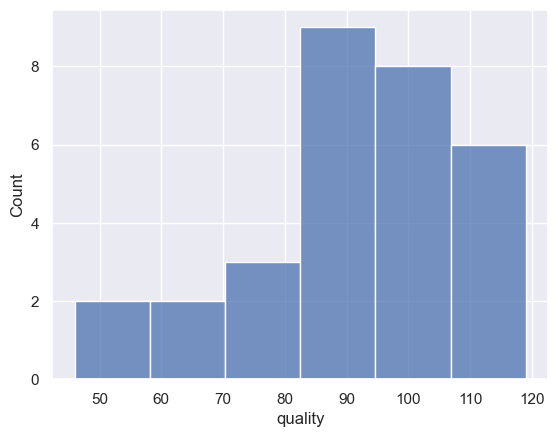

In [ ]:
sns.histplot(df["quality"]);
#px.histogram(df["quality"]);

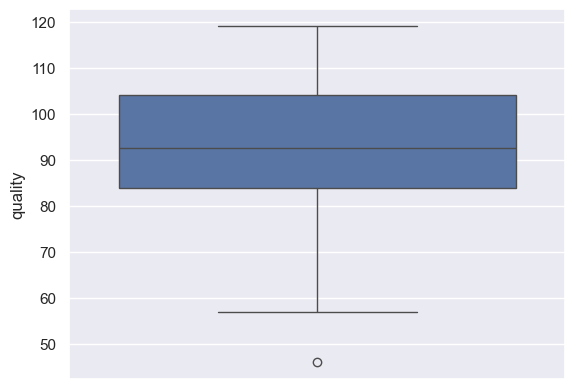

In [ ]:
sns.boxplot(df["quality"]);

* Obtain the mean and standard deviation of quality measurement, for the different machines (unpooled mean/standard deviation)

In [ ]:
df.groupby("machine")[["quality"]].agg(["mean", "std"])

/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_73675/4058271444.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("machine")[["quality"]].agg(["mean", "std"])


quality           
           mean        std
machine                   
M0         76.0  19.634154
M1        106.2  11.819475
M2         87.8  12.794530
M3        111.6   7.569676
M4         90.0  10.770330
M5         86.0  19.222383

* Draw boxplots of quality for the different factories

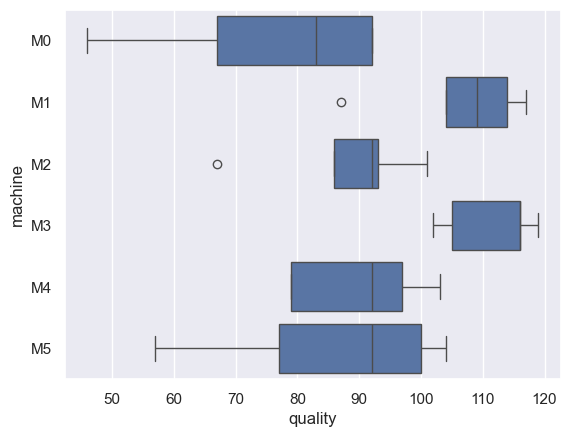

In [ ]:
sns.boxplot(data=df, x="quality", y="machine");
#px.box(df, x="quality", y="machine")

Even from a classical analysis, there seems to be evidence that different machines have different quality.

## Pooled Bayesian Model

Consider the following *pooled* Bayesian model:
\begin{align*}
\mu &\sim N(90, 10) \\
\sigma &\sim \text{HalfNormal}(36) \\
\vec{y}_{ij} &\sim N(\mu, \sigma) \\
\end{align*}


* Discuss the pooled model and its underlying hypotheses

* Implement the pooled model in pymc

## Unpooled Bayesian Model

Consider the following Bayesian unpooled model
\begin{align*}
\mu_{j} &\sim {N}(90, 20) \\
\sigma_{j} &\sim \text{HalfNormal}(23) \\
\vec{y}_{ij} &\sim {N}(\mu_j, \sigma_j) \\
\end{align*}



* Discuss the unpooled model and its underlying hypotheses

* Implement the unpooled model in pymc

* Compare the sample unpooled standard deviation with the Bayesian estimate. What do you observe?

## Hierarchical model, common std

Consider the following Bayesian hierarchical model:

\begin{align*}
\mu_\mu & \sim N(90, 10)\\
\sigma_\mu  & \sim \text{HalfNormal}(30) \\
\mu_{j} &\sim {N}(\mu_\mu, \sigma_\mu) \\
\sigma &\sim \text{HalfNormal}(23) \\
\vec{y}_{ij} &\sim {N}(\mu_j, \sigma) \\
\end{align*}



* Discuss the hierarchical model and its underlying hypotheses

* Implement the hierarchical model in pymc

## Model selection

What is the best model ultimately? In our case: Pooled, Unpooled, or Hierarchical?


To answer this question, we need a **model selection** strategy/metric.

* You know metrics for point regression models (mse, rmse, mae,...)
* You know metrics for point classification models (accuracy, prediciton, recall...)


### The WAIC Criterion
To score full Bayesian models, we need a metric that evaluates a (sample-based approximation of a) *distribution*.

* A popular metric to score a distribution is the log-pointwise-predictive-density ${\rm lpd}(y, \Theta)$:
$$ {\rm lpd}(y, \Theta) = \sum_i \log \frac{1}{S} \sum_s p(y_i | \Theta_s),$$
where $y$ are the observations and $\Theta$ is the sample-based approximation of the posterior ($\Theta_s$ is a single MCMC draw). It is the (approximate) logarithm of the expected likelihood (the higher, the better)!


* The ${\rm lpd}(y, \Theta)$ generally increases for increasing model complexity and it is thus prone to overfitting when used on the same data used for model building. It should be evaluated with fresh data in (cross)-validation.

* The WAIC criterion (the lower, the better) balances high ${\rm lpd}$ and low model complexity explicitly. It can be applied directly on the training data $y$!

\begin{align}
{\rm WAIC}(y, \Theta) &= -2(\rm{lpd} - p_{\rm waic}).\\
 p_{{\rm waic}} &= \sum_i {\rm var}_{\theta} \log p(y_i|\theta)
\end{align}

* The WAIC is equivalent up to a factor to the ${\rm elpd}$, the *expected* $\rm{lpd}$ on fresh data (the higher, the better):

$${\rm elpd}(y, \Theta) = \rm{lpd} - p_{\rm waic}.$$

Advantages of WAIC/elpd:

* Well-defined both for continuous and for categorical observations
* Applicable to Bayesian models returning point-wise estimates
* Applicable to the training data directly (built-in complexity penalty)
* Works well in practice

Note: WAIC stands for Widely Applicable Information Criterion!

### The WAIC Criterion in arviz

Arviz has a built-in function `az.waic` to compute the WAIC (actually, as of v0.12.1, arviz computes the ${\rm elpd}$, see <a href="https://python.arviz.org/en/v0.12.1/api/generated/arviz.waic.html?highlight=waic">documentation</a>):


In [ ]:
az.waic(trace_pooled)

NameError: name 'trace_pooled' is not defined

There is an even more convenient method to evaluate the criterion on several models and rank them according to the WAIC criterion (from best to worst, ascending WAIC/descending elpd)

In [ ]:
#with factory_pooled, factory_separate, factory_hierarchical:
comp_df = az.compare({"model_pooled": trace_pooled,
                      "model_unpooled": trace_unpooled,
                      "model_hierarchical": trace_hierarchical},
                      ic="waic") # ic stands for "information criterion"
comp_df

In [ ]:
az.plot_compare(comp_df);

## Posterior predictions of new measurements

* Given the pooled model, make a prediction for a new measurement

* Given the unpooled model, make a prediction for a new measurement of the machine M1